# Assignment 4
## Description
In this assignment you must read in a file of metropolitan regions and associated sports teams from [assets/wikipedia_data.html](assets/wikipedia_data.html) and answer some questions about each metropolitan region. Each of these regions may have one or more teams from the "Big 4": NFL (football, in [assets/nfl.csv](assets/nfl.csv)), MLB (baseball, in [assets/mlb.csv](assets/mlb.csv)), NBA (basketball, in [assets/nba.csv](assets/nba.csv) or NHL (hockey, in [assets/nhl.csv](assets/nhl.csv)). Please keep in mind that all questions are from the perspective of the metropolitan region, and that this file is the "source of authority" for the location of a given sports team. Thus teams which are commonly known by a different area (e.g. "Oakland Raiders") need to be mapped into the metropolitan region given (e.g. San Francisco Bay Area). This will require some human data understanding outside of the data you've been given (e.g. you will have to hand-code some names, and might need to google to find out where teams are)!

For each sport I would like you to answer the question: **what is the win/loss ratio's correlation with the population of the city it is in?** Win/Loss ratio refers to the number of wins over the number of wins plus the number of losses. Remember that to calculate the correlation with [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html), so you are going to send in two ordered lists of values, the populations from the wikipedia_data.html file and the win/loss ratio for a given sport in the same order. Average the win/loss ratios for those cities which have multiple teams of a single sport. Each sport is worth an equal amount in this assignment (20%\*4=80%) of the grade for this assignment. You should only use data **from year 2018** for your analysis -- this is important!

## Notes

1. Do not include data about the MLS or CFL in any of the work you are doing, we're only interested in the Big 4 in this assignment.
2. I highly suggest that you first tackle the four correlation questions in order, as they are all similar and worth the majority of grades for this assignment. This is by design!
3. It's fair game to talk with peers about high level strategy as well as the relationship between metropolitan areas and sports teams. However, do not post code solving aspects of the assignment (including such as dictionaries mapping areas to teams, or regexes which will clean up names).
4. There may be more teams than the assert statements test, remember to collapse multiple teams in one city into a single value!

## Question 1
For this question, calculate the win/loss ratio's correlation with the population of the city it is in for the **NHL** using **2018** data.

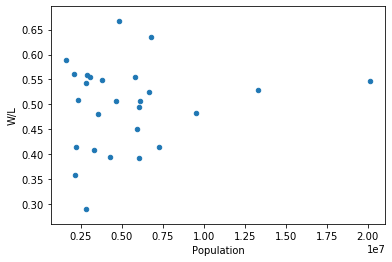

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
from io import StringIO

pd.set_option('display.max_rows', 200)


def read_html(filename):
    str = ""
    with open(filename, encoding="utf8") as file:
        str = file.read()
    str = re.sub(r"<a href=\"[^\"]*\" title=\"([^\"]*)\">[^<]*</a>", r"\1;", str)
    return pd.read_html(StringIO(str))

def read_cities():
    cities=read_html("assets/wikipedia_data.html")[1]
    cities=cities.iloc[:-1,[0,3,5,6,7,8]]
    cities.rename(columns = {'Population (2016 est.)[8]' : 'Population'}, inplace=True)
    cols = ['NFL','MLB','NBA','NHL']
    cities[cols] = cities[cols].apply(lambda x : x.apply(lambda y: y.split('[')[0]))
    cities[cols] = cities[cols].apply(lambda x : x.apply(lambda y: y if len(y)>2 else ''))
    return cities

def read_csv(filename):
    str = ""
    with open(filename) as file:
        for line in file:
            c = line.split(',')
            if re.sub(r"[^a-zA-Z0-9.]","",c[0]) != re.sub(r"[^a-zA-Z]","",c[1]):
                str += line + '\n'
    return pd.read_csv(StringIO(str))

def cleanup_team(df):
    df.drop(labels=df.columns.difference(['team','W','L','year','League']), axis=1, inplace=True)
    df['team'] = df['team'].apply(lambda x: re.sub(r"[^a-zA-Z ]*$", "", x))
    
def calc_wl(df):
    df['W/L']=df['W']/(df['W']+df['L'])
    return df

def read_nhl():
    df = read_csv("assets/nhl.csv")
    cleanup_team(df)
    return df

def read_nfl():
    df = read_csv("assets/nfl.csv")    
    cleanup_team(df)
    return df

def read_mlb():
    df = read_csv("assets/mlb.csv")    
    cleanup_team(df)
    return df

def read_nba():
    df = read_csv("assets/nba.csv")    
    cleanup_team(df)
    return df

def trans_cities(cities):
    cities.rename(columns={"Metropolitan area;":"Metropolitan area"}, inplace=True)
    cities["Metropolitan area"] = cities["Metropolitan area"].apply(lambda x: x[0:len(x)-1])
    citiest = pd.melt(cities, id_vars=['Metropolitan area','Population'])
    citiest.rename(columns={"variable":"League"}, inplace=True)
    teams = citiest['value'].apply(lambda x: np.append(x.split(';'),np.full(9, fill_value=None))[0:9])
    citiest = pd.concat([citiest, pd.DataFrame.from_records(teams.values, teams.index)], axis=1)
    citiest.drop(columns=['value'], inplace=True)
    citiest = pd.melt(citiest, id_vars=['Metropolitan area','Population','League'])
    citiest['value']=citiest['value'].apply(lambda x: x if x == None or len(x.strip()) != 0 else None)
    citiest.rename(columns={"value":"team"}, inplace=True)
    citiest.drop(columns=['variable'], inplace=True)
    citiest.dropna(inplace=True)
    citiest['Population'] = pd.to_numeric(citiest['Population'])
    return citiest

def fix(cities2, nhl, nfl, mlb, nba):
    cities2.loc[cities2['team']=='Texas Rangers (baseball)','team'] = 'Texas Rangers'
    nhl.loc[nhl['team']=='Phoenix Coyotes','team'] = 'Arizona Coyotes'
    nfl.loc[nfl['team']=='San Diego Chargers','team'] = 'Los Angeles Chargers'
    nfl.loc[nfl['team']=='St. Louis Rams','team'] = 'Los Angeles Rams'
    mlb.loc[mlb['team']=='Los Angeles Angels of Anaheim','team'] = 'Los Angeles Angels'
    nba.loc[nba['team']=='Charlotte Bobcats','team'] = 'Charlotte Hornets'

def validate(cities2, nhl, nfl, mlb, nba):
    #1
    assert len(cities2), len((cities2['League']+cities2['team']).unique())
    #2
    s = set(nhl['team'].unique())|set(nfl['team'].unique())|set(mlb['team'].unique())|set(nba['team'].unique())
    w = set(cities2['team'])
    if len(s.symmetric_difference(w))!=0:
        print(s.symmetric_difference(w))
    assert len(s.symmetric_difference(w))==0
    #3
    assert nhl.dtypes['team'] == 'object' and nhl.dtypes['W'] == 'int64' and nhl.dtypes['L'] == 'int64' and nhl.dtypes['year'] == 'int64' and nhl.dtypes['League'] == 'object'
    assert nfl.dtypes['team'] == 'object' and nfl.dtypes['W'] == 'int64' and nfl.dtypes['L'] == 'int64' and nfl.dtypes['year'] == 'int64' and nfl.dtypes['League'] == 'object'
    assert mlb.dtypes['team'] == 'object' and mlb.dtypes['W'] == 'int64' and mlb.dtypes['L'] == 'int64' and mlb.dtypes['year'] == 'int64' and mlb.dtypes['League'] == 'object'
    assert nba.dtypes['team'] == 'object' and nba.dtypes['W'] == 'int64' and nba.dtypes['L'] == 'int64' and nba.dtypes['year'] == 'int64' and nhl.dtypes['League'] == 'object'
    return 'ok'

def lookup(cities2, df):
    return pd.merge(cities2, df, how='inner', left_on=['League','team'], right_on=['League','team'])

def prep():
    global nhl, nfl, mlb, nba, cities2
    nhl = read_nhl()
    nfl = read_nfl()
    mlb = read_mlb()
    nba = read_nba()
    cities = read_cities()
    cities2 = trans_cities(cities)
    fix(cities2, nhl, nfl, mlb, nba)
    validate(cities2, nhl, nfl, mlb, nba)
    nhl = lookup(cities2, nhl)
    nfl = lookup(cities2, nfl)
    mlb = lookup(cities2, mlb)
    nba = lookup(cities2, nba)
    
def calc(df):
    calc_wl(df)
    df = df[df['year']==2018].drop(columns=['year','team','W','L']).groupby(['Metropolitan area','Population','League'], as_index=False).agg('mean')
    return df

import matplotlib as plt
%matplotlib inline

def plot9(df):
    df = calc(df)
    df.plot(x='Population', y='W/L', kind='scatter')

prep()
plot9(mlb)

In [5]:
prep()

def nhl_correlation(): 
    df=calc(nhl)
    
    population_by_region = df['Population'] 
    win_loss_by_region = df['W/L'] 

    assert len(population_by_region) == len(win_loss_by_region), "Q1: Your lists must be the same length"
    assert len(population_by_region) == 28, "Q1: There should be 28 teams being analysed for NHL"
    
    return stats.pearsonr(population_by_region, win_loss_by_region)[0]

(0.012486162921209886, 0.9497182859911791)

## Question 2
For this question, calculate the win/loss ratio's correlation with the population of the city it is in for the **NBA** using **2018** data.

In [ ]:
prep()

def nba_correlation():
    df = calc(nba)
    
    population_by_region = df['Population']
    win_loss_by_region = df['W/L'] 

    assert len(population_by_region) == len(win_loss_by_region), "Q2: Your lists must be the same length"
    assert len(population_by_region) == 28, "Q2: There should be 28 teams being analysed for NBA"

    return stats.pearsonr(population_by_region, win_loss_by_region)[0]

## Question 3
For this question, calculate the win/loss ratio's correlation with the population of the city it is in for the **MLB** using **2018** data.

In [ ]:
prep()

def mlb_correlation(): 
    df = calc(mlb)
    
    population_by_region = df['Population']
    win_loss_by_region = df['W/L'] 

    assert len(population_by_region) == len(win_loss_by_region), "Q3: Your lists must be the same length"
    assert len(population_by_region) == 26, "Q3: There should be 26 teams being analysed for MLB"

    return stats.pearsonr(population_by_region, win_loss_by_region)[0]

## Question 4
For this question, calculate the win/loss ratio's correlation with the population of the city it is in for the **NFL** using **2018** data.

In [ ]:
prep()

def nfl_correlation(): 
    df = calc(nfl)
    
    population_by_region = df['Population']
    win_loss_by_region = df['W/L'] 

    assert len(population_by_region) == len(win_loss_by_region), "Q4: Your lists must be the same length"
    assert len(population_by_region) == 29, "Q4: There should be 29 teams being analysed for NFL"

    return stats.pearsonr(population_by_region, win_loss_by_region)[0]

## Question 5
In this question I would like you to explore the hypothesis that **given that an area has two sports teams in different sports, those teams will perform the same within their respective sports**. How I would like to see this explored is with a series of paired t-tests (so use [`ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)) between all pairs of sports. Are there any sports where we can reject the null hypothesis? Again, average values where a sport has multiple teams in one region. Remember, you will only be including, for each sport, cities which have teams engaged in that sport, drop others as appropriate. This question is worth 20% of the grade for this assignment.

In [ ]:
prep()

def sports_team_performance():
    sports = ['NFL', 'NBA', 'NHL', 'MLB']
    p_values = pd.DataFrame({k:np.nan for k in sports}, index=sports)
    
    df = pd.concat([calc(mlb),calc(nhl),calc(nfl),calc(nba)], ignore_index=True)

    for x in sports:
        for y in sports:
            if x != y:
                dd = pd.merge(df[df['League']==x].drop(columns=['Population','League']),df[df['League']==y].drop(columns=['Population','League']), how="inner", left_on='Metropolitan area', right_on='Metropolitan area')
                p_values.loc[x,y]=stats.ttest_rel(dd['W/L_x'], dd['W/L_y'])[1]
    
    assert abs(p_values.loc["NBA", "NHL"] - 0.02) <= 1e-2, "The NBA-NHL p-value should be around 0.02"
    assert abs(p_values.loc["MLB", "NFL"] - 0.80) <= 1e-2, "The MLB-NFL p-value should be around 0.80"
    return p_values